In [1]:
from pathlib import Path
import numpy as np
import cv2
import pydicom
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import math
import random
from sklearn.metrics import roc_auc_score

data_path = "../input/rsna-miccai-voxel-128-dataset/voxel"

In [2]:

import sys
sys.path.append('../input/efficientnet-voxel/EfficientNet-PyTorch-3D-master')
from efficientnet_pytorch_3d import EfficientNet3D

In [3]:
def load_voxel(study_id, scan_type="FLAIR", split="train", sz=128):
    assert sz in (64, 128, 256)
    data_root = Path(f"../input/rsna-miccai-voxel-{sz}-dataset")
    npy_path = Path(data_root).joinpath("voxel", split, study_id, f"{scan_type}.npy")
    voxel = np.load(str(npy_path))
    return voxel


In [4]:
# flair = load_voxel("00000")


# fig = plt.figure(figsize=(15, 15))
# ax = fig.add_subplot(1, 2, 1)
# ax.imshow(flair[64], cmap='gray')
# a1 = cv2.rotate(flair[64], cv2.ROTATE_90_CLOCKWISE)
# ax = fig.add_subplot(1, 2, 2)
# ax.imshow(a1, cmap='gray')

# fig = plt.figure(figsize=(6, 6))
# plt.axis('off')


# num=64
# for i in range(128):
#     ax = fig.add_subplot(12, 12, i+1)
#     ax.axis('off')
#     ax.imshow(flair[i], cmap='gray')

In [5]:
def load_3d_image_alltypes(id, split="train"):
    
    # flair
    
    flair=load_voxel(id,"FLAIR",split)
    t1w=load_voxel(id,"T1w",split)
    t1wce=load_voxel(id,"T1wCE",split)
    t2w=load_voxel(id,"T2w",split)
    
    data=np.array((flair, t1w, t1wce, t2w))
    
    rotate = np.random.randint(0,4)
    for i in range(4):
        for j in range(128):
            if rotate:
                rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
                data[i][j] = cv2.rotate(data[i][j], rot_choices[rotate])
            
    return data


In [6]:
# data=load_3d_image_alltypes("00000")

In [7]:
# fig = plt.figure(figsize=(6, 6))

# num=64
# for i in range(128):
#     ax = fig.add_subplot(12, 12, i+1)
#     ax.axis('off')
#     ax.imshow(data[3][i], cmap='gray')

In [8]:
class Data(Dataset):
  def __init__(self, path=data_path, split="train", validation_split = 0.8):
    train_df=pd.read_csv("../input/csvfiles/train_labels.csv")
    self.labels={}
    self.split=split
    id=list(train_df["BraTS21ID"])
    value=list(train_df["MGMT_value"])
    for i, j in zip(id, value):
      self.labels[str(i).zfill(5)]=j

    idlist = sorted(glob.glob(f"{data_path}/train/*"))
    self.ids=[i.split("/")[-1] for i in idlist]
    
    
    
    if split=="train":
        self.split=split
        self.ids=self.ids[:int(len(self.ids)*validation_split)]
        self.ids.remove('00109')
        self.ids.remove('00123')
    elif split=="valid":
        self.split=split
        self.ids=self.ids[int(len(self.ids)*validation_split):]
        self.ids.remove('00709')

  def __len__(self):
    return len(self.ids)
      
  def __getitem__(self,index):
    image=load_3d_image_alltypes(self.ids[index])
    image = image - image.min()
    image = (image + 1e-5) / (image.max() - image.min() + 1e-5)
    if self.split=="test":
      return torch.tensor(image, dtype=torch.float32), self.ids[index]
    else:
      label = self.labels[self.ids[index]]
      return torch.tensor(image, dtype = torch.float32), torch.tensor(label, dtype = torch.long)

class TestData(Dataset):
  def __init__(self, path=data_path, split="test"):
    train_df=pd.read_csv("../input/csvfiles/train_labels.csv")
    
    self.split=split

    idlist = sorted(glob.glob(f"{data_path}/test/*"))
    self.ids=[i.split("/")[-1] for i in idlist]
    
  def __len__(self):
    return len(self.ids)

  def __getitem__(self,index):
    image=load_3d_image_alltypes(self.ids[index],split="test")
    # image = image - np.min(image)
    # image = image / np.max(image)

    image = image - image.min()
    image = (image + 1e-5) / (image.max() - image.min() + 1e-5)

    return torch.tensor(image, dtype=torch.float32), self.ids[index]

In [9]:
a=TestData(split="test")
len(a.ids)

87

In [10]:
test_dataset = TestData(split="test")
test_bs = 16
test_loader = DataLoader(test_dataset, batch_size = test_bs, shuffle=False)

In [11]:

# for data in val_loader:
#     x, y = data
#     print(y)
#     break

In [12]:
for img, idx in test_loader:
    print(img.shape)
    print(img.max())
    print(img.mean())
    print(img.min())
    print(idx)
    break

torch.Size([16, 4, 128, 128, 128])
tensor(1.)
tensor(0.1570)
tensor(3.9216e-08)
('00001', '00013', '00015', '00027', '00037', '00047', '00079', '00080', '00082', '00091', '00114', '00119', '00125', '00129', '00135', '00145')


In [16]:
net_path="../input/axiel-plane-net/best_roc_0.58_loss_3.47.pt"

model = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=4)

# model._conv_stem = Conv2dStaticSamePadding(4, 32, kernel_size = (3,3), stride = (2,2), bias = False, image_size = 512)
# model._fc = torch.nn.Linear(in_features=1280, out_features=2, bias=True)

model.load_state_dict(torch.load(net_path))
model.eval()

gpu = torch.device(f"cuda:0")
model.to(gpu)

EfficientNet3D(
  (_conv_stem): Conv3dStaticSamePadding(
    4, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm3d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock3D(
      (_depthwise_conv): Conv3dStaticSamePadding(
        32, 32, kernel_size=(3, 3, 3), stride=[2, 2, 2], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1, 0, 1), value=0.0)
      )
      (_bn1): BatchNorm3d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv3dStaticSamePadding(
        32, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv3dStaticSamePadding(
        8, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv3dStaticS

In [17]:
# predict
model.to(gpu)

labels={}

model.eval()

for i, data in enumerate(test_loader, 0):
  x, index = data
  x = x.to(gpu)
  # ru=x
  outputs = model(x)
#   output=outputs
#   print(outputs)
  label = torch.softmax(outputs,dim=1)[:,1]
#   print(index)
#   print(label)
  # break
  label = label.tolist()
  for j, idx in enumerate(list(index)):
    labels[idx] = labels.get(idx, []) + [label[j]]
  
  # break


import collections
labels_od = collections.OrderedDict(sorted(labels.items()))
print(labels_od)


f_idxs = []
f_labels = []
for idx in labels_od.keys():
    f_idxs.append(int(idx))
    f_labels.append(np.array(labels_od[idx], dtype = np.float32).mean()) 
    
    
submission = pd.read_csv("../input/csvfiles/sample_submission.csv")

for i, row in submission.iterrows():
    idx = int(row['BraTS21ID'])
    try:
        new_label = f_labels[f_idxs.index(idx)]
        submission.loc[i, 'MGMT_value'] = float(new_label)
    except:
        pass


submission.to_csv("submission.csv", index=False)

OrderedDict([('00001', [0.496591717004776]), ('00013', [0.496591717004776]), ('00015', [0.496591717004776]), ('00027', [0.496591717004776]), ('00037', [0.496591717004776]), ('00047', [0.496591717004776]), ('00079', [0.496591717004776]), ('00080', [0.496591717004776]), ('00082', [0.496591717004776]), ('00091', [0.496591717004776]), ('00114', [0.496591717004776]), ('00119', [0.496591717004776]), ('00125', [0.496591717004776]), ('00129', [0.496591717004776]), ('00135', [0.496591717004776]), ('00145', [0.496591717004776]), ('00153', [0.496591717004776]), ('00161', [0.496591717004776]), ('00163', [0.496591717004776]), ('00174', [0.496591717004776]), ('00181', [0.496591717004776]), ('00182', [0.496591717004776]), ('00190', [0.496591717004776]), ('00200', [0.496591717004776]), ('00208', [0.496591717004776]), ('00213', [0.496591717004776]), ('00229', [0.496591717004776]), ('00252', [0.496591717004776]), ('00256', [0.496591717004776]), ('00264', [0.496591717004776]), ('00287', [0.49659171700477

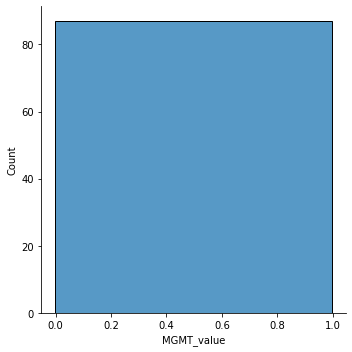

In [18]:
import seaborn as sns

sns.displot(submission["MGMT_value"])